## Apress - Industrialized Machine Learning Examples

Andreas Francois Vermeulen
2019

### This is an example add-on to a book and needs to be accepted as part of that copyright.

## Andre, Laurence, Bobby optimize their Bicycle Paint Shop using pyschedule

Andre and Laurence are running a paint shop for bicycles where they recycle old bicycles with fresh colors. Today they have to paint a green and a red bicycle. To get started they import pyschedule and create a new scenario. We use hours as granularity and expect a working day of at most 10 hours, so we set the planning horizon to 10. Some solvers do not need this parameter, but the default solver requires it:

In [1]:
from pyschedule import Scenario, solvers, plotters
S = Scenario('Bicycle_Paint_Shop', horizon=10)

Then they create themselves as resources:

In [2]:
Andre = S.Resource('Andre')
Laurence = S.Resource('Laurence')
Bobby = S.Resource('Bobby')

Painting a bicycle takes two hours. Moreover, after the bicycle has been painted, it needs to get post-processed (e.g. tires Preped) which takes one hour (which is the default). This translates into four tasks in total:

In [3]:
Green_Paint, Red_Paint, Blue_Paint = S.Task('Green_Paint', length=2), S.Task('Red_Paint', length=3), S.Task('Blue_Paint', length=1)
Green_Prep, Red_Prep, Blue_Prep = S.Task('Green_Prep', length=1), S.Task('Red_Prep', length=1), S.Task('Blue_Prep', length=3)

Clearly, one can only do the post-processing after the painting with an arbitrary gap in between. For the red paint we are a little stricter, here we want to start the post-processing exactly one hour after the painting since this is the time the color takes to dry:

In [4]:
S += Green_Paint < Green_Prep, Red_Paint + 1 <= Red_Prep, Blue_Paint + 2 <= Blue_Prep

Each task can be done by either Andre or Laurence:

In [5]:
Green_Paint += Laurence|Bobby
Green_Prep += Laurence

Red_Paint += Andre|Laurence|Bobby
Red_Prep += Andre|Laurence

Blue_Paint += Andre|Laurence|Bobby
Blue_Prep += Andre|Laurence|Bobby

So lets have a look at the scenario:

In [6]:
S.clear_solution()
print(S)

###############################################

SCENARIO: Bicycle_Paint_Shop / horizon: 10

OBJECTIVE: None

RESOURCES:
Andre
Laurence
Bobby

TASKS:
Green_Paint : Laurence|Bobby
Red_Paint : Andre|Laurence|Bobby
Blue_Paint : Andre|Laurence|Bobby
Green_Prep : Laurence
Red_Prep : Andre|Laurence
Blue_Prep : Andre|Laurence|Bobby

JOINT RESOURCES:
Laurence|Bobby : Green_Paint
Andre|Laurence|Bobby : Red_Paint
Andre|Laurence|Bobby : Blue_Paint
Andre|Laurence : Red_Prep
Andre|Laurence|Bobby : Blue_Prep

LAX PRECEDENCES:
Green_Paint < Green_Prep

TIGHT PRECEDENCES:
Red_Paint + 1 <= Red_Prep
Blue_Paint + 2 <= Blue_Prep

###############################################


We havent defined an objective yet. We want to finish all tasks as early as possible, and so we use the MakeSpan and check the scenario again:

In [7]:
S.use_makespan_objective()
print(S)

###############################################

SCENARIO: Bicycle_Paint_Shop / horizon: 10

OBJECTIVE: MakeSpan

RESOURCES:
Andre
Laurence
Bobby

TASKS:
Green_Paint : Laurence|Bobby
Red_Paint : Andre|Laurence|Bobby
Blue_Paint : Andre|Laurence|Bobby
Green_Prep : Laurence
Red_Prep : Andre|Laurence
Blue_Prep : Andre|Laurence|Bobby
MakeSpan : Andre

JOINT RESOURCES:
Laurence|Bobby : Green_Paint
Andre|Laurence|Bobby : Red_Paint
Andre|Laurence|Bobby : Blue_Paint
Andre|Laurence : Red_Prep
Andre|Laurence|Bobby : Blue_Prep

LAX PRECEDENCES:
Green_Paint < Green_Prep
Green_Paint < MakeSpan
Red_Paint < MakeSpan
Blue_Paint < MakeSpan
Green_Prep < MakeSpan
Red_Prep < MakeSpan
Blue_Prep < MakeSpan

TIGHT PRECEDENCES:
Red_Paint + 1 <= Red_Prep
Blue_Paint + 2 <= Blue_Prep

###############################################


Hence, we want to minimize the position of the MakeSpan task subject to the constraint that it is scheduled after all other tasks. Thus, the position of the MakeSpan is the length of our schedule. Now we have the first version of our scenario, lets solve and plot it:

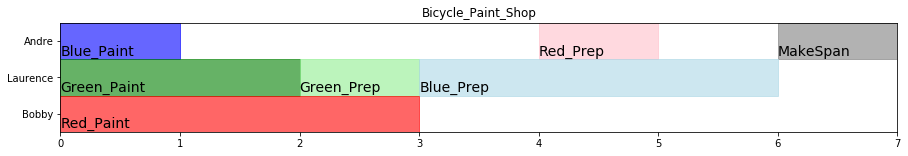

In [8]:
# Set some colors for the tasks
task_colors = { Green_Paint    : 'green',
                Green_Prep     : 'lightgreen', 
                Red_Paint      : 'red',
                Red_Prep       : 'pink',
                Blue_Paint     : 'blue',
                Blue_Prep      : 'lightblue',
                S['MakeSpan']  : 'grey'}

# A small helper method to solve and plot a scenario
def run(S) :
    if solvers.mip.solve(S):
        %matplotlib inline
        plotters.matplotlib.plot(S,task_colors=task_colors,fig_size=(15,2))
    else:
        print('no solution exists')
run(S)

Note that it could happen that somebody needs to paints the red bicycle and then do the green post-processing. This would be annoying, switching bicycles takes too much time. We use the following constraints to ensure that the green/red painting and post-processing is always done by the same persons:

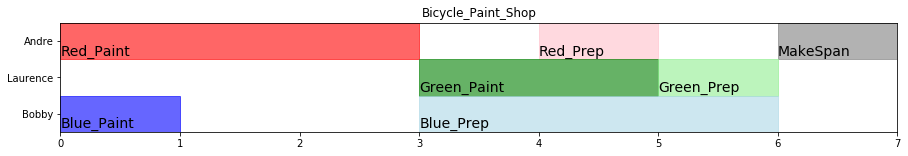

In [9]:
# Green_Prep will use the same resources as Green_Paint if there is an overlap in resource requirement
Green_Prep += Green_Paint*[Andre,Laurence,Bobby]
# same for Red_Prep and Red_Paint
Red_Prep += Red_Paint*[Andre,Laurence,Bobby]
# same for Blue_Prep and Blue_Paint
Blue_Prep += Blue_Paint*[Andre,Laurence,Bobby]

run(S)

This schedule completes after four hours and suggests to paint both bicycles at the same time. However, Andre and Laurence have only a single paint shop which they need to share:

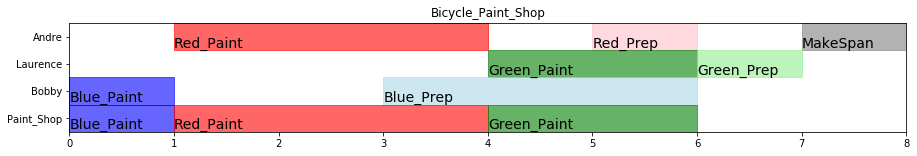

In [10]:
Paint_Shop = S.Resource('Paint_Shop')
Red_Paint += Paint_Shop
Green_Paint += Paint_Shop
Blue_Paint += Paint_Shop
run(S)

Great, everybody can still go home after five hours and have a late lunch! Unfortunately, Andre receives a call that the red bicycle will only arrive after two hours:

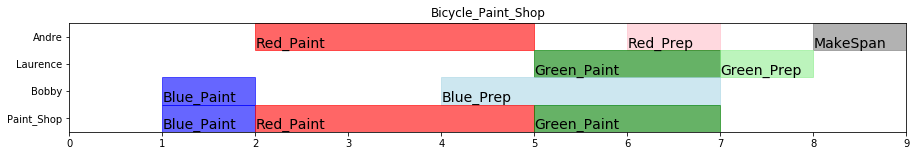

In [11]:
S += Red_Paint > 2
run(S)

Too bad, everything takes now size hours to finish. Therefore Bobby and Laurence decide to schedule a lunch after the third hour and before the fifth hour:

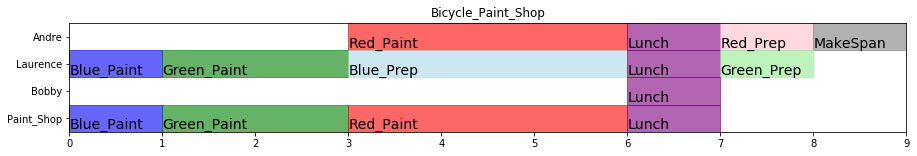

In [12]:
Lunch = S.Task('Lunch')
Lunch += {Andre, Laurence, Bobby, Paint_Shop}
S += Lunch > 2, Lunch < 9
task_colors[Lunch] = 'purple'
S.clear_objective() #we need to remove the objective and readd it because of the new lunch task
S.use_makespan_objective()
task_colors[S['MakeSpan']] = 'grey'
run(S)

Andre is a morning person and  wants to finish three hours of work before lunch, that is, before the third hour:

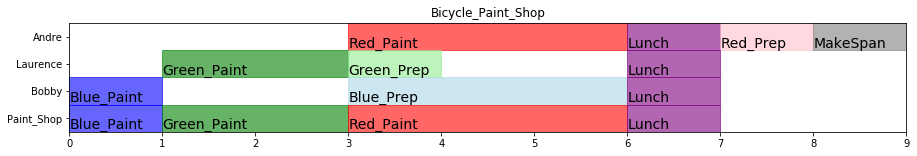

In [13]:
S += Andre['length'][0:4] >= 1
run(S)

The weather forecast is really good for the afternoon, so Andre and Laurence decide to close the shop after lunch, that is, they fix the horizon to 5 hours. Unfortunately, the following happens:

In [14]:
S.horizon = 5
run(S)

no solution exists


#### Andre, Laurence and Bobby needs 14 hours,  they fix the horizon to 10 hours. 

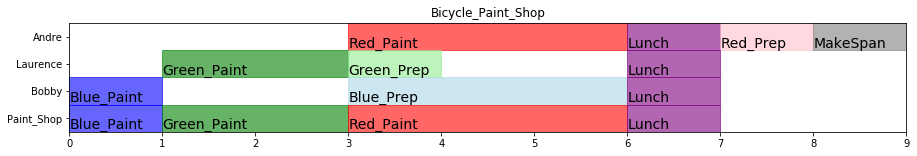

In [15]:
S.horizon = 10
run(S)

## Well Done you can run the Paint Shop.

In [16]:
import datetime
now = datetime.datetime.now()
print('Done!',str(now))

Done! 2019-04-27 18:03:32.610168
